# Analyze Taiwan credit default data

This Jupyter notebook will construct neural network models that are trained using the tensorflow.keras API framework in Python. 

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

import math

print(tf.__version__)

2.4.1


The following command helped Jupyter notebook's autocomplete in this document. 

In [2]:
%config Completer.use_jedi = False

## Credit default dataset

The data describe default status on Taiwan credit card clients. The dataset is pulled from https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients. The source of the dataset is cited as 

I-Cheng Yeh; icyeh '@' chu.edu.tw; Department of Information Management, Chung Hua University, Taiwan. Department of Civil Engineering, Tamkang University, Taiwan.
other contact information: 886-2-26215656 ext. 3181

#### Load the dataset

In [3]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls'
raw_dataset = pd.read_excel(url, skiprows = 1)
raw_dataset.keys()

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')

The original columns are

- LIMIT_BAL: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.
- SEX: Gender (1 = male; 2 = female).
- EDUCATION: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).
- MARRIAGE: Marital status (1 = married; 2 = single; 3 = others).
- AGE: Age (year).
- PAY0 - PAY6: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.
- BILL_AMT1 - BILL_AMT6: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005.
- PAY_AMT1 - PAY_AMT6: Amount of previous payment (NT dollar). X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;X23 = amount paid in April, 2005.
- default payment next month: binary indicator of whether or not the next month's credit bill was paid.  

#### Keep only certain columns, rename to sentence case

We'll only work with the columns that specifically describe individual attributes (sex, education, etc.) for easier interpretation of the results. Also, convert some of the names to sentence case and rename the response variable to "Default". 

In [4]:
keep_names = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'default payment next month']
raw_dataset = raw_dataset.loc[:, keep_names]

In [5]:
raw_dataset.rename(columns = {'LIMIT_BAL':'Limit', 'SEX':'Sex', 'EDUCATION':'Education', 
                              'MARRIAGE':'Marriage', 'AGE':'Age', 'default payment next month':'Default'}, 
                  inplace = True)

## Clean the data

Check for NA values

In [6]:
raw_dataset.isna().sum()

Limit        0
Sex          0
Education    0
Marriage     0
Age          0
Default      0
dtype: int64

The columns "Sex", "Education", and "Marriage" are categorical variables. Convert each of these into one-hot-encoded vectors. 

In [7]:
raw_dataset['Sex'] = raw_dataset['Sex'].map({1:'Male', 2:'Female'})
raw_dataset['Education'] = raw_dataset['Education'].map({1:'Graduate', 2:'University', 3:'Highschool', 4:'Other_school'})
raw_dataset['Marriage'] = raw_dataset['Marriage'].map({1:'Married', 2:'Single', 3:'Other_relationship'})

In [8]:
dataset = pd.get_dummies(raw_dataset, columns=['Sex', 'Education', 'Marriage'], prefix = '', prefix_sep = '')

In [9]:
dataset.tail()

,Limit,Age,Default,Female,Male,Graduate,Highschool,Other_school,University,Married,Other_relationship,Single
29995,220000,39,0,0,1,0,1,0,0,1,0,0
29996,150000,43,0,0,1,0,1,0,0,0,0,1
29997,30000,37,1,0,1,0,0,0,1,0,0,1
29998,80000,41,1,0,1,0,1,0,0,1,0,0
29999,50000,46,1,0,1,0,0,0,1,1,0,0


## Split dataset into test and train sets

Split data into train, validation, and test sets. 

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
train_df, test_df = train_test_split(dataset, test_size = 0.2)
train_df, val_df = train_test_split(train_df, test_size = 0.2)

## Inspect the data

In [12]:
train_df.describe().transpose()[['mean','std']]

,mean,std
Limit,168019.375000,129843.088801
Age,35.516198,9.262404
Default,0.220990,0.414924
Female,0.605313,0.488796
Male,0.394688,0.488796
Graduate,0.356042,0.478840
Highschool,0.164635,0.370861
Other_school,0.004010,0.063202
University,0.463542,0.498682
Married,0.449844,0.497491


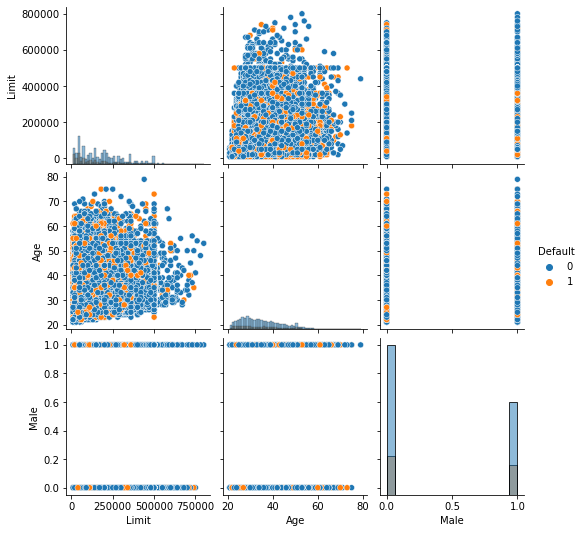

In [13]:
sns.pairplot(train_df[['Limit', 'Age', 'Default', 'Male']], hue = "Default", diag_kind = 'hist')

Some general things to note: from top left to bottom right, diagonal plots indicate that default is more likely to occur on credit cards that have 
- 1. lower limits
- 2. younger owners
- 3. male owners

## Separate features from labels

The following commands store features and labels in seperate dataframes. 

In [15]:
train_features = train_df.copy()
val_features = val_df.copy()
test_features = test_df.copy()

train_labels = train_features.pop('Default')
val_labels = val_features.pop('Default')
test_labels = test_features.pop('Default')

Make a note of how many features are in the train_features dataset.

In [16]:
train_features.shape

(19200, 11)

## Normalize continuous predictors 

Build a normalizer that will be incorporated as a layer in the neural networks. 

In [17]:
normalizer = preprocessing.Normalization()

Adapt the normalizer to the training dataset. 

In [18]:
normalizer.adapt(np.array(train_features))

In [19]:
normalizer.mean, normalizer.variance

(<tf.Variable 'mean:0' shape=(11,) dtype=float32, numpy=
 array([1.6801938e+05, 3.5516197e+01, 6.0531253e-01, 3.9468750e-01,
        3.5604167e-01, 1.6463542e-01, 4.0104166e-03, 4.6354166e-01,
        4.4984376e-01, 1.0572917e-02, 5.3776044e-01], dtype=float32)>,
 <tf.Variable 'variance:0' shape=(11,) dtype=float32, numpy=
 array([1.6858350e+10, 8.5787651e+01, 2.3890927e-01, 2.3890927e-01,
        2.2927600e-01, 1.3753060e-01, 3.9943331e-03, 2.4867079e-01,
        2.4748436e-01, 1.0461130e-02, 2.4857415e-01], dtype=float32)>)

## Build a logistic regression model

We'll construct the model in a manner that allows us to choose the output_bias in the last layer. If chosen properly, choosing the output_bias will make training more efficient. 

In [20]:
def Linear_Logistic_Model(output_bias = None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = tf.keras.Sequential([
        normalizer, layers.Dense(units = 1, 
                                bias_initializer = output_bias)
    ])
    
    model.compile(
    optimizer=keras.optimizers.Adam(lr=1e-3),
    loss=keras.losses.BinaryCrossentropy(from_logits = True), 
    metrics=['accuracy'])

    return model

#### Derive an appropriate output bias

In later steps, the final output of the neural network will be converted into a probability using a sigmoid activation layer of the form $\sigma(z) = \frac{e^z}{1 + e^z}$. Here, $z = \sum w_i x_i + b$ is the output of the last layer of our neural network, the $x_i$ are the feature values, $w_i$ are weights, and $b$ is an intercept. We can choose the intercept so that, prior to any training and with weights initialized near 0, the model will predict the probability of default of any given sample is equal to the proportion of defaults in the training data. Choosing the intercept in this way makes training more efficient. 

Let $\hat{p}$ be the proportion of observations with default status 1. Then a logical baseline prediction of our model is 
\begin{equation} 
\sigma(z) = \frac{e^z}{1 + e^z} = \hat{p}
\end{equation}

If weights are initialized near 0 then $z \approx b$. Solving the above equation for b yields
\begin{equation}
    b = \log(\frac{\hat{p}}{1 - \hat{p}}).
\end{equation}
 In words, the intercept b should be initialized to the log-odds ratio of the dataset. Here, "log" refers to the base e logarithm. Next, calculate $\hat{p}$ from our dataset. 


In [32]:
phat = train_labels.sum() / len(train_labels)
phat

0.22098958333333332

The appropriate output bias is the log-odds of phat

In [37]:
train_output_bias = math.log(phat/(1 - phat))
train_output_bias

-1.2599088514570018

## Construct the model with appropriate output bias

In [38]:
Base_Logistic_Model = Linear_Logistic_Model(output_bias = train_output_bias)

In [39]:
Base_Logistic_Model.predict(train_features[:11])

array([[-0.51614124],
       [-1.4263155 ],
       [-0.7052172 ],
       [ 0.01092565],
       [-1.5304643 ],
       [-1.6567768 ],
       [-1.0728717 ],
       [-2.9034014 ],
       [-0.4156534 ],
       [-0.21666658],
       [-2.3009195 ]], dtype=float32)

## Compile and fit the model to the training data

In [40]:
history_linear = Base_Logistic_Model.fit(
    train_features, train_labels, 
    epochs=10,
    verbose=1,
    validation_split = 0.2)

Epoch 1/10
480/480 [==============================] - 2s 4ms/step - loss: 0.5998 - accuracy: 0.7687 - val_loss: 0.5477 - val_accuracy: 0.7714
Epoch 2/10
480/480 [==============================] - 2s 3ms/step - loss: 0.5370 - accuracy: 0.7736 - val_loss: 0.5298 - val_accuracy: 0.7714
Epoch 3/10
480/480 [==============================] - 2s 3ms/step - loss: 0.5284 - accuracy: 0.7709 - val_loss: 0.5256 - val_accuracy: 0.7737
Epoch 4/10
480/480 [==============================] - 2s 5ms/step - loss: 0.5118 - accuracy: 0.7828 - val_loss: 0.5246 - val_accuracy: 0.7737
Epoch 5/10
480/480 [==============================] - 2s 4ms/step - loss: 0.5164 - accuracy: 0.7755 - val_loss: 0.5244 - val_accuracy: 0.7737
Epoch 6/10
480/480 [==============================] - 2s 4ms/step - loss: 0.5180 - accuracy: 0.7768 - val_loss: 0.5244 - val_accuracy: 0.7737
Epoch 7/10
480/480 [==============================] - 2s 5ms/step - loss: 0.5176 - accuracy: 0.7762 - val_loss: 0.5244 - val_accuracy: 0.7737
Epoch 

## Make a plot of model performance across epochs

In [41]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 0.6])
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)

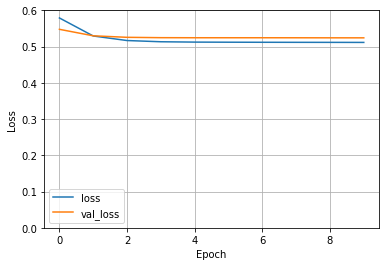

In [42]:
plot_loss(history_linear)

## Save model error on validation and test data

In [ ]:
val_linear = history['']

In [47]:
history.history['val_loss']

[0.5476833581924438,
 0.5297865867614746,
 0.5256031155586243,
 0.5246275067329407,
 0.5244415402412415,
 0.5244265198707581,
 0.524422287940979,
 0.5243647694587708,
 0.5242334008216858,
 0.5241853594779968]

## Add hidden layers to the neural network

We'll add two hidden layers, each progressively smaller than the last. To help avoid over-fitting, we also add a dropout layer. The dropout layer strengthens meaningful connections during training by ignoring a fraction of randomly chosen outputs from the previous layer. In this case, we choose a relatively large proportion (50%) of inputs to ignore.  

In [50]:
def Deep_Logistic_Model(output_bias = None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = tf.keras.Sequential([
        normalizer, 
        layers.Dense(units = 8, 
                                bias_initializer = output_bias), 
        layers.Dense(units = 4, 
                                bias_initializer = output_bias),        
        layers.Dropout(0.5),
        layers.Dense(units = 1, 
                                bias_initializer = output_bias)
    ])
    
    model.compile(
    optimizer=keras.optimizers.Adam(lr=1e-3),
    loss=keras.losses.BinaryCrossentropy(from_logits = True), 
    metrics=['accuracy'])

    return model

In [51]:
Deep_Logistic_Model = Deep_Logistic_Model(output_bias = train_output_bias)

In [52]:
history_deep = Deep_Logistic_Model.fit(
    train_features, train_labels, 
    epochs=10,
    verbose=1,
    validation_split = 0.2)

Epoch 1/10
480/480 [==============================] - 3s 4ms/step - loss: 0.7753 - accuracy: 0.7164 - val_loss: 0.5371 - val_accuracy: 0.7714
Epoch 2/10
480/480 [==============================] - 2s 3ms/step - loss: 0.5439 - accuracy: 0.7754 - val_loss: 0.5242 - val_accuracy: 0.7737
Epoch 3/10
480/480 [==============================] - 3s 6ms/step - loss: 0.5146 - accuracy: 0.7833 - val_loss: 0.5230 - val_accuracy: 0.7737
Epoch 4/10
480/480 [==============================] - 2s 5ms/step - loss: 0.5209 - accuracy: 0.7776 - val_loss: 0.5233 - val_accuracy: 0.7737
Epoch 5/10
480/480 [==============================] - 2s 5ms/step - loss: 0.5146 - accuracy: 0.7812 - val_loss: 0.5227 - val_accuracy: 0.7737
Epoch 6/10
480/480 [==============================] - 2s 5ms/step - loss: 0.5125 - accuracy: 0.7825 - val_loss: 0.5223 - val_accuracy: 0.7737
Epoch 7/10
480/480 [==============================] - 3s 7ms/step - loss: 0.5126 - accuracy: 0.7803 - val_loss: 0.5225 - val_accuracy: 0.7737
Epoch 

## Interpretation and conclusions

One of the things I've grown to love about my experience in science is that your expectations are always challenged. In this case, fitting a more complicated model to the Taiwan credit default dataset did not result in a greater validation accuracy. Given the predictors that this modeling approach uses, the simple logistic regression model is just as accurate on the more complicated deep neural network. Consequently, I will move forward with the simpler linear regression model. Out of curiosity, we the linear and deep networks on the test data: 

In [53]:
Deep_Logistic_Model.evaluate(test_features, test_labels)

188/188 [==============================] - 2s 7ms/step - loss: 0.5103 - accuracy: 0.7842


[0.5102972984313965, 0.784166693687439]

In [55]:
Base_Logistic_Model.evaluate(test_features, test_labels)

188/188 [==============================] - 1s 5ms/step - loss: 0.5113 - accuracy: 0.7842


[0.5113459229469299, 0.784166693687439]

The outputs above show the cross-entropy and accuracy of the models applied to test data. As expected from the training stage (and validation datasets), the linear logistic regression model is competitive with the more complicated deep neural network. 

## Add a softmax layer to the chosen neural network

The base logistic regression model outputs the logits of predictions. Here, we add a "cap" to the model so that the outputs are probabilities. 